In [1]:
import matplotlib.tri as tri
import matplotlib.path as mpath
import matplotlib.pyplot as plt
import matplotlib as mpl

import os
import pandas as pd
import numpy as np
import xarray as xr
from glob import glob
from pathlib import Path
from datetime import datetime
from matplotlib.backends.backend_pdf import PdfPages

from scipy.optimize import curve_fit
from matplotlib import colors as mpl_col


try:
    import numexpr as ne
    neAvail = True
except:
    warnings.warn("numexpr not available", Warning)
    neAvail = False

import pyPamtra

begin_time = datetime.now()

selfld = '/data/inscape/icon/pamtra_runs/haloac3/seltrack/'
gpsfld = '/data/inscape/icon/pamtra_runs/haloac3/gpstrack/'
runfld = selfld

# Define descriptorFiles
descriptorFile1mom = np.array([ # TODO to be reviewed, coefficients for m-D and v-D are changing
  #['hydro_name' 'as_ratio' 'liq_ice' 'rho_ms' 'a_ms' 'b_ms' 'alpha_as' 'beta_as' 'moment_in' 'nbin' 'dist_name' 'p_1' 'p_2' 'p_3' 'p_4' 'd_1' 'd_2' 'scat_name' 'vel_size_mod' 'canting']
   ('cwc_q', 1.0,  1, -99.0,   -99.0, -99.0,  -99.0, -99.0,  3,  1,   'mono',           -99.0, -99.0, -99.0, -99.0,  2.0e-5,  -99.0, 'mie-sphere', 'corPowerLaw_24388657.6_2.0', -99.0),
   ('iwc_q', 0.2, -1, -99.0,   130.0,   3.0,  0.684,   2.0,  3,  1,   'mono_cosmo_ice', -99.0, -99.0, -99.0, -99.0,   -99.0,  -99.0, 'ssrg-rt3_0.18_0.89_2.06_0.08', 'corPowerLaw_30.606_0.5533', -99.0),
   ('rwc_q', 1.0,  1, -99.0,   -99.0, -99.0,  -99.0, -99.0,  3,  100, 'exp',            -99.0, -99.0, 8.0e6, -99.0,  1.2e-4, 6.0e-3, 'mie-sphere', 'corPowerLaw_130.0_0.5', -99.0),
   ('swc_q', 0.6, -1, -99.0,   0.038,   2.0, 0.3971,  1.88,  3,  100, 'exp_cosmo_snow', -99.0, -99.0, -99.0, -99.0, 5.1e-11, 1.0e-2, 'ssrg-rt3_0.25_1.00_1.66_0.04', 'corPowerLaw_4.9_0.25', -99.0),
   ('gwc_q', 1.0, -1, -99.0,   169.6,   3.1,  -99.0, -99.0,  3,  100, 'exp',            -99.0, -99.0, 4.0e6, -99.0, 1.0e-10, 1.0e-2, 'mie-sphere', 'corPowerLaw_406.67_0.85', -99.0)
],)

In [2]:
# This goes through the flights one at a time
# it does the simulations and produce a plot for each of them as usual
# at the end it collects all the data and make a 2D histogram for all of the available data
# [ for i in np.arange(3,18,1)] # from 03 to 17

Zeflat = []
Hgtflat = []
SNRflat = []
Nflat = []

for fln in np.arange(3,18,1): # start at 3 stops at 17 included
    flightnumber = '{:02d}'.format(fln)
    #flightnumber = '13'
    gpsfile = glob(gpsfld + 'gps_????????_RF{}.nc'.format(flightnumber))[0]
    trackfile = glob(selfld + 'sel_nwp_????????_RF{}.nc'.format(flightnumber))[0]
    datestr = trackfile.split('_')[-2]
    gpsdata = xr.open_dataset(gpsfile)

    sel_nwp_data = xr.open_dataset(trackfile)

    grp_time_data = [pd.to_datetime(t).strftime('%Y%m%d%H%M%S')+'_{:09d}'.format(nc) for t,nc in zip(sel_nwp_data.time.values,
                                                                                                     sel_nwp_data.ncells.values)]
    group_time_cell_nwp = xr.DataArray(data=grp_time_data,
                                       dims=['time'], coords={'time':sel_nwp_data.time})
    v_north = xr.DataArray(data=gpsdata.v_north,
                           dims=['time'], coords={'time':sel_nwp_data.time})
    v_east = xr.DataArray(data=gpsdata.v_east,
                           dims=['time'], coords={'time':sel_nwp_data.time})
    gpsdata_alt = xr.DataArray(data=gpsdata.alt.values,
                               dims=['time'], coords={'time':sel_nwp_data.time})
    sel_nwp_data = sel_nwp_data.assign(group_time_cell=group_time_cell_nwp,
                                       v_north=v_north, v_east=v_east,
                                       alt=gpsdata_alt)
    data_groups = sel_nwp_data.reset_coords().groupby('group_time_cell')
    nwp_data = data_groups.mean() # they should be all equal

    data = nwp_data
    nhydros = len(descriptorFile1mom)
    pamDat = dict()

    Ncells = data.dims['group_time_cell']
    pamDat['lat'] = np.rad2deg(data.clat.values)
    pamDat['lon'] = np.rad2deg(data.clon.values)
    Nh = data.dims['height']
    shapeSFC = (Ncells,)
    hgt = (nwp_data.alt - nwp_data.z_mc).values
    one = np.ones((hgt.shape[0],1))
    fake_hgt = np.linspace(-100.0*one, -1*one, hgt.shape[1], axis=1)[:,:,0]
    hgt[hgt < 0] = fake_hgt[hgt < 0]
    pamDat['hgt'] = hgt
    pamDat['press']  = data.pres.values    # pressure
    pamDat['temp']   = data.temp.values   # temperature
    wind_u = (data.u-1.0*data.v_east).values # zonal wind speed
    wind_v = (data.v-1.0*data.v_north).values # meridional wind speed
    pamDat['wind_uv'] = np.hypot(wind_u, wind_v)
    wind_w = data.w.values # vertical wind speed
    pamDat['wind_w'] = -0.5*(wind_w[...,:-1]+wind_w[...,1:]) #sign change due to conventions: for model upward is positive; in pamtra downward velocity is positive 
    pamDat['relhum'] = data.rh.values*0.01
    print('ICON max RH ', np.max(pamDat['relhum']))

    hydro_cmpl = np.zeros((Ncells, Nh, nhydros)) + np.nan
    hydro_cmpl[..., 0] = data.tot_qc_dia.values   # specific cloud water content
    hydro_cmpl[..., 1] = data.tot_qi_dia.values   # specific cloud ice content
    hydro_cmpl[..., 2] = data.qr.values   # rain mixing ratio
    hydro_cmpl[..., 3] = data.qs.values   # snow mixing ratio
    hydro_cmpl[..., 4] = data.qg.values   # graupel mixing ratio

    pamDat["hydro_q"] = hydro_cmpl
    pamDat['groundtemp'] = data.isel(height=-1).temp.values
    print('ICON max RH ', np.max(pamDat['relhum']))

    # surface properties
    pamDat['sfc_type']  = np.ones(pamDat['groundtemp'].shape)
    pamDat['sfc_model'] = np.zeros(pamDat['groundtemp'].shape)
    pamDat['sfc_refl']  = np.chararray(pamDat['groundtemp'].shape)
    pamDat['sfc_refl'][:] = 'S' # land  'F' # ocean 'L' lambertian, land

    pam = pyPamtra.pyPamtra()
    #pam.set['pyVerbose'] = verbosity
    for df in descriptorFile1mom:
          pam.df.addHydrometeor(df)

    pam.createProfile(**pamDat)
    pam.nmlSet['passive'] = False
    pam.set['pyVerbose'] = 0 # Set to 0 to avoid a lot of output

    #pam.p['radar_prop']
    pam.p['turb_edr'][:] = 1.0e-4
    
    #------------------------------------------------------------------------------
    # PARAMETERS
    #------------------------------------------------------------------------------
    
    RunNo = 5
    pam.nmlSet['radar_attenuation'] = 'bottom-up'
    pam.nmlSet['radar_fwhr_beamwidth_deg'] = 1.0
    pam.nmlSet['radar_integration_time'] = 2.0
    pam.nmlSet['radar_k2'] = 0.93
    pam.nmlSet['radar_max_v'] = 15.99
    pam.nmlSet['radar_min_v'] = -15.99
    pam.nmlSet['radar_nfft'] = 256
    pam.nmlSet['radar_pnoise0'] = -30
    pam.nmlSet['radar_no_ave'] = 40
    pam.nmlSet['radar_peak_min_snr'] = -25
    pam.nmlSet['radar_mode'] = 'spectrum' 

    #--------------------------------------------------------------------------------
    # Get data
    
    pam.runParallelPamtra(np.array([35.6]), pp_deltaX=50, pp_deltaY=1, pp_deltaF=1, pp_local_workers=2)
    
    # Get Ze back into data
    Ze = xr.DataArray(data=pam.r['Ze'][:, 0, ::-1, 0, 0, 0], # flip again heights
                      dims=['group_time_cell', 'height'],
                      coords={'group_time_cell':data.group_time_cell, 'height':data.height})
    data = data.assign(Ze=Ze)

    SNR = xr.DataArray(data=pam.r['radar_snr'][:, 0, ::-1, 0, 0, 0], # flip again heights
                       dims=['group_time_cell', 'height'],
                       coords={'group_time_cell':data.group_time_cell, 'height':data.height})
    data = data.assign(SNR=SNR)

    hgt = xr.DataArray(data=pam.r['radar_hgt'][:,0,::-1],
                       dims=['group_time_cell', 'height'],
                       coords={'group_time_cell':data.group_time_cell, 'height':data.height})
    data = data.assign(radar_hgt=hgt)
    
    
    print(datetime.now() - begin_time)
    
    # ---------------------------------------------------------------------------------
    # Check reflectivity
    
    pam.r['Ze'].shape

    hgt_plot=data.z_mc.isel(group_time_cell=0).values[::-1]
    def dB(x):
        return 10.0*np.log10(x)
    
    
    Ze = data.sel(group_time_cell=group_time_cell_nwp).Ze.values.T
    radar_hgt = data.sel(group_time_cell=group_time_cell_nwp).radar_hgt.values.T
    Ze[Ze<-40] = np.nan
    track = xr.open_dataset(gpsfile)
    """
    cmap = 'Spectral'
    fig, ax1 = plt.subplots(1, 1, figsize=(14, 5))
    #fig.suptitle('Flightdate: {}'.format('20220315'), x=0.15, fontsize=12)
    mesh_pamtra = ax1.pcolormesh(track.time,
                                 1.0e-3*hgt_plot,
                                 Ze, vmin=-40, vmax=40, cmap=cmap)
    plt.colorbar(mesh_pamtra, ax=ax1, label="Reflectivity (dBZ)")
    ax1.set_ylim(0, 13)
    ax1.set_title('Model data')
    ax1.set_xlabel("Time")
    ax1.set_ylabel("Height (km)")
    fig.tight_layout()
    
    fig, ax1 = plt.subplots(1, 1, figsize=(14, 5))
    mesh_pamtra = ax1.pcolormesh(track.time,
                                 radar_hgt*1.0e-3,
                                 Ze, vmin=-40, vmax=40, cmap='viridis')
    plt.colorbar(mesh_pamtra, ax=ax1, label="SNR (dB)")
    ax1.set_ylim(0, 13)
    ax1.set_title('Model data')
    ax1.set_xlabel("Time")
    ax1.set_ylabel("range (km)")
    fig.tight_layout()
    """

    
    # Signal to Noise Ratio #

    SNR = data.sel(group_time_cell=group_time_cell_nwp).SNR.values.T
    SNR[SNR<-80] = np.nan
    track = xr.open_dataset(gpsfile)
    """
    fig, ax1 = plt.subplots(1, 1, figsize=(14, 5))
    #fig.suptitle('Flightdate: {}'.format('20220315'), x=0.15, fontsize=12)
    mesh_pamtra = ax1.pcolormesh(track.time,
                                 1.0e-3*hgt_plot,
                                 SNR, vmin=-40, vmax=40, cmap=cmap)
    plt.colorbar(mesh_pamtra, ax=ax1, label="SNR (dB)")
    ax1.set_ylim(0, 13)
    ax1.set_title('Model data')
    ax1.set_xlabel("Time")
    ax1.set_ylabel("Height (km)")
    
    fig, ax1 = plt.subplots(1, 1, figsize=(14, 5))
    #fig.suptitle('Flightdate: {}'.format('20220315'), x=0.15, fontsize=12)
    mesh_pamtra = ax1.pcolormesh(track.time,
                                 radar_hgt*1.0e-3,
                                 SNR, vmin=-40, vmax=40, cmap='viridis')
    plt.colorbar(mesh_pamtra, ax=ax1, label="SNR (dB)")
    ax1.set_ylim(0, 13)
    ax1.set_title('Model data')
    ax1.set_xlabel("Time")
    ax1.set_ylabel("range (km)")
    fig.tight_layout()
    """   
    
    # Noise #
    N = Ze - SNR
    """
    fig, ax1 = plt.subplots(1, 1, figsize=(14, 5))
    #fig.suptitle('Flightdate: {}'.format('20220315'), x=0.15, fontsize=12)
    mesh_pamtra = ax1.pcolormesh(track.time,
                                 1.0e-3*hgt_plot,
                                 N, vmin=-40, vmax=0, cmap=cmap)
    plt.colorbar(mesh_pamtra, ax=ax1, label="Noise (dB)")
    ax1.set_ylim(0, 13)
    ax1.set_title('Model data')
    ax1.set_xlabel("Time")
    ax1.set_ylabel("Height (km)")
    fig.tight_layout()
    
    fig, ax1 = plt.subplots(1, 1, figsize=(14, 5))
    #fig.suptitle('Flightdate: {}'.format('20220315'), x=0.15, fontsize=12)
    mesh_pamtra = ax1.pcolormesh(track.time,
                                 radar_hgt*1.0e-3,
                                 N, vmin=-40, vmax=-10, cmap='viridis')
    plt.colorbar(mesh_pamtra, ax=ax1, label="Noise (dB)")
    ax1.set_ylim(0, 13)
    ax1.set_title('Model data')
    ax1.set_xlabel("Time")
    ax1.set_ylabel("range (km)")
    fig.tight_layout()
    """
    
    # ------------------------------------------------------------------------------------
    
    """
    cmap='viridis'
    fig = plt.figure()
    Y = Ze.flatten()
    X = radar_hgt.flatten()*1.0e-3
    res = plt.hist2d(Y,X, bins=(50,25), range=((-65, 40),(0,14)), cmap=cmap, norm=mpl_col.LogNorm())
    plt.xlabel('reflectivity [dBZ]')
    plt.ylabel('range [km]')
    plt.title(pd.to_datetime(track.time.mean().values).strftime('%Y-%m-%d'))

    fig = plt.figure()
    Y = SNR.flatten()
    res = plt.hist2d(Y,X, bins=(50,25), range=((-85, 40),(0,14)), cmap=cmap, norm=mpl_col.LogNorm())
    plt.xlabel('SNR [dB]')
    plt.ylabel('range [km]')
    plt.title(pd.to_datetime(track.time.mean().values).strftime('%Y-%m-%d'))

    fig = plt.figure()
    Y = N.flatten()
    res = plt.hist2d(Y,X, bins=(50,50), range=((-45, -0),(0,14)), cmap=cmap, norm=mpl_col.LogNorm())

    mask = (np.isfinite(X) * (np.isfinite(Y)))
    def func(x, a):
        return a*x*x;
    popt, pcov = curve_fit(func, X[mask], 10.0**(0.1*Y[mask]))
    x = np.linspace(0.1, 12, 100)
    y = func(x, *popt)
    plt.plot(dB(y), x, c='red')
    plt.text(-35, 6, 'P0={:.2f}'.format(dB(popt[0])), fontsize=14, color='white')
    plt.xlabel('noise [dB]')
    plt.ylabel('range [km]')
    plt.title(pd.to_datetime(track.time.mean().values).strftime('%Y-%m-%d'))
    """
    # Append to list
    
    Zeflat.append(Ze.flatten())
    Hgtflat.append(radar_hgt.flatten()*1.0e-3)
    SNRflat.append(SNR.flatten())
    Nflat.append(N.flatten())
    
    
    
    

ICON max RH  1.0035275
ICON max RH  1.0035275


/home/dori/lib/python/pyPamtra/core.py:821: Warning: timestamp set to now
  warnings.warn("timestamp set to now", Warning)
/home/dori/lib/python/pyPamtra/core.py:838: Warning: wind10u set to 0
  warnings.warn("%s set to %s"%(environment,preset,), Warning)
/home/dori/lib/python/pyPamtra/core.py:838: Warning: wind10v set to 0
  warnings.warn("%s set to %s"%(environment,preset,), Warning)
/home/dori/lib/python/pyPamtra/core.py:838: Warning: sfc_salinity set to 33.0
  warnings.warn("%s set to %s"%(environment,preset,), Warning)
/home/dori/lib/python/pyPamtra/core.py:838: Warning: sfc_slf set to 1.0
  warnings.warn("%s set to %s"%(environment,preset,), Warning)
/home/dori/lib/python/pyPamtra/core.py:838: Warning: sfc_sif set to 0.0
  warnings.warn("%s set to %s"%(environment,preset,), Warning)
/home/dori/lib/python/pyPamtra/core.py:871: Warning: obs_height set to [833000.0, 0.0]
  warnings.warn("%s set to %s"%(environment,preset,), Warning)
/home/dori/lib/python/pyPamtra/core.py:881: Warnin

0:18:04.278545
ICON max RH  1.0045714
ICON max RH  1.0045714


/home/dori/lib/python/pyPamtra/core.py:821: Warning: timestamp set to now
  warnings.warn("timestamp set to now", Warning)
/home/dori/lib/python/pyPamtra/core.py:838: Warning: wind10u set to 0
  warnings.warn("%s set to %s"%(environment,preset,), Warning)
/home/dori/lib/python/pyPamtra/core.py:838: Warning: wind10v set to 0
  warnings.warn("%s set to %s"%(environment,preset,), Warning)
/home/dori/lib/python/pyPamtra/core.py:838: Warning: sfc_salinity set to 33.0
  warnings.warn("%s set to %s"%(environment,preset,), Warning)
/home/dori/lib/python/pyPamtra/core.py:838: Warning: sfc_slf set to 1.0
  warnings.warn("%s set to %s"%(environment,preset,), Warning)
/home/dori/lib/python/pyPamtra/core.py:838: Warning: sfc_sif set to 0.0
  warnings.warn("%s set to %s"%(environment,preset,), Warning)
/home/dori/lib/python/pyPamtra/core.py:871: Warning: obs_height set to [833000.0, 0.0]
  warnings.warn("%s set to %s"%(environment,preset,), Warning)
/home/dori/lib/python/pyPamtra/core.py:881: Warnin

0:25:36.226512
ICON max RH  1.0000595
ICON max RH  1.0000595


/home/dori/lib/python/pyPamtra/core.py:821: Warning: timestamp set to now
  warnings.warn("timestamp set to now", Warning)
/home/dori/lib/python/pyPamtra/core.py:838: Warning: wind10u set to 0
  warnings.warn("%s set to %s"%(environment,preset,), Warning)
/home/dori/lib/python/pyPamtra/core.py:838: Warning: wind10v set to 0
  warnings.warn("%s set to %s"%(environment,preset,), Warning)
/home/dori/lib/python/pyPamtra/core.py:838: Warning: sfc_salinity set to 33.0
  warnings.warn("%s set to %s"%(environment,preset,), Warning)
/home/dori/lib/python/pyPamtra/core.py:838: Warning: sfc_slf set to 1.0
  warnings.warn("%s set to %s"%(environment,preset,), Warning)
/home/dori/lib/python/pyPamtra/core.py:838: Warning: sfc_sif set to 0.0
  warnings.warn("%s set to %s"%(environment,preset,), Warning)
/home/dori/lib/python/pyPamtra/core.py:871: Warning: obs_height set to [833000.0, 0.0]
  warnings.warn("%s set to %s"%(environment,preset,), Warning)
/home/dori/lib/python/pyPamtra/core.py:881: Warnin

0:41:41.504471
ICON max RH  0.9999999
ICON max RH  0.9999999


/home/dori/lib/python/pyPamtra/core.py:821: Warning: timestamp set to now
  warnings.warn("timestamp set to now", Warning)
/home/dori/lib/python/pyPamtra/core.py:838: Warning: wind10u set to 0
  warnings.warn("%s set to %s"%(environment,preset,), Warning)
/home/dori/lib/python/pyPamtra/core.py:838: Warning: wind10v set to 0
  warnings.warn("%s set to %s"%(environment,preset,), Warning)
/home/dori/lib/python/pyPamtra/core.py:838: Warning: sfc_salinity set to 33.0
  warnings.warn("%s set to %s"%(environment,preset,), Warning)
/home/dori/lib/python/pyPamtra/core.py:838: Warning: sfc_slf set to 1.0
  warnings.warn("%s set to %s"%(environment,preset,), Warning)
/home/dori/lib/python/pyPamtra/core.py:838: Warning: sfc_sif set to 0.0
  warnings.warn("%s set to %s"%(environment,preset,), Warning)
/home/dori/lib/python/pyPamtra/core.py:871: Warning: obs_height set to [833000.0, 0.0]
  warnings.warn("%s set to %s"%(environment,preset,), Warning)
/home/dori/lib/python/pyPamtra/core.py:881: Warnin

0:52:34.957659
ICON max RH  1.0008264
ICON max RH  1.0008264


/home/dori/lib/python/pyPamtra/core.py:821: Warning: timestamp set to now
  warnings.warn("timestamp set to now", Warning)
/home/dori/lib/python/pyPamtra/core.py:838: Warning: wind10u set to 0
  warnings.warn("%s set to %s"%(environment,preset,), Warning)
/home/dori/lib/python/pyPamtra/core.py:838: Warning: wind10v set to 0
  warnings.warn("%s set to %s"%(environment,preset,), Warning)
/home/dori/lib/python/pyPamtra/core.py:838: Warning: sfc_salinity set to 33.0
  warnings.warn("%s set to %s"%(environment,preset,), Warning)
/home/dori/lib/python/pyPamtra/core.py:838: Warning: sfc_slf set to 1.0
  warnings.warn("%s set to %s"%(environment,preset,), Warning)
/home/dori/lib/python/pyPamtra/core.py:838: Warning: sfc_sif set to 0.0
  warnings.warn("%s set to %s"%(environment,preset,), Warning)
/home/dori/lib/python/pyPamtra/core.py:871: Warning: obs_height set to [833000.0, 0.0]
  warnings.warn("%s set to %s"%(environment,preset,), Warning)
/home/dori/lib/python/pyPamtra/core.py:881: Warnin

1:08:35.333580
ICON max RH  1.0007817
ICON max RH  1.0007817


/home/dori/lib/python/pyPamtra/core.py:821: Warning: timestamp set to now
  warnings.warn("timestamp set to now", Warning)
/home/dori/lib/python/pyPamtra/core.py:838: Warning: wind10u set to 0
  warnings.warn("%s set to %s"%(environment,preset,), Warning)
/home/dori/lib/python/pyPamtra/core.py:838: Warning: wind10v set to 0
  warnings.warn("%s set to %s"%(environment,preset,), Warning)
/home/dori/lib/python/pyPamtra/core.py:838: Warning: sfc_salinity set to 33.0
  warnings.warn("%s set to %s"%(environment,preset,), Warning)
/home/dori/lib/python/pyPamtra/core.py:838: Warning: sfc_slf set to 1.0
  warnings.warn("%s set to %s"%(environment,preset,), Warning)
/home/dori/lib/python/pyPamtra/core.py:838: Warning: sfc_sif set to 0.0
  warnings.warn("%s set to %s"%(environment,preset,), Warning)
/home/dori/lib/python/pyPamtra/core.py:871: Warning: obs_height set to [833000.0, 0.0]
  warnings.warn("%s set to %s"%(environment,preset,), Warning)
/home/dori/lib/python/pyPamtra/core.py:881: Warnin

1:18:54.293030
ICON max RH  0.99999946
ICON max RH  0.99999946


/home/dori/lib/python/pyPamtra/core.py:821: Warning: timestamp set to now
  warnings.warn("timestamp set to now", Warning)
/home/dori/lib/python/pyPamtra/core.py:838: Warning: wind10u set to 0
  warnings.warn("%s set to %s"%(environment,preset,), Warning)
/home/dori/lib/python/pyPamtra/core.py:838: Warning: wind10v set to 0
  warnings.warn("%s set to %s"%(environment,preset,), Warning)
/home/dori/lib/python/pyPamtra/core.py:838: Warning: sfc_salinity set to 33.0
  warnings.warn("%s set to %s"%(environment,preset,), Warning)
/home/dori/lib/python/pyPamtra/core.py:838: Warning: sfc_slf set to 1.0
  warnings.warn("%s set to %s"%(environment,preset,), Warning)
/home/dori/lib/python/pyPamtra/core.py:838: Warning: sfc_sif set to 0.0
  warnings.warn("%s set to %s"%(environment,preset,), Warning)
/home/dori/lib/python/pyPamtra/core.py:871: Warning: obs_height set to [833000.0, 0.0]
  warnings.warn("%s set to %s"%(environment,preset,), Warning)
/home/dori/lib/python/pyPamtra/core.py:881: Warnin

1:23:37.687948
ICON max RH  0.99999917
ICON max RH  0.99999917


/home/dori/lib/python/pyPamtra/core.py:821: Warning: timestamp set to now
  warnings.warn("timestamp set to now", Warning)
/home/dori/lib/python/pyPamtra/core.py:838: Warning: wind10u set to 0
  warnings.warn("%s set to %s"%(environment,preset,), Warning)
/home/dori/lib/python/pyPamtra/core.py:838: Warning: wind10v set to 0
  warnings.warn("%s set to %s"%(environment,preset,), Warning)
/home/dori/lib/python/pyPamtra/core.py:838: Warning: sfc_salinity set to 33.0
  warnings.warn("%s set to %s"%(environment,preset,), Warning)
/home/dori/lib/python/pyPamtra/core.py:838: Warning: sfc_slf set to 1.0
  warnings.warn("%s set to %s"%(environment,preset,), Warning)
/home/dori/lib/python/pyPamtra/core.py:838: Warning: sfc_sif set to 0.0
  warnings.warn("%s set to %s"%(environment,preset,), Warning)
/home/dori/lib/python/pyPamtra/core.py:871: Warning: obs_height set to [833000.0, 0.0]
  warnings.warn("%s set to %s"%(environment,preset,), Warning)
/home/dori/lib/python/pyPamtra/core.py:881: Warnin

1:31:33.685079
ICON max RH  0.99999946
ICON max RH  0.99999946


/home/dori/lib/python/pyPamtra/core.py:821: Warning: timestamp set to now
  warnings.warn("timestamp set to now", Warning)
/home/dori/lib/python/pyPamtra/core.py:838: Warning: wind10u set to 0
  warnings.warn("%s set to %s"%(environment,preset,), Warning)
/home/dori/lib/python/pyPamtra/core.py:838: Warning: wind10v set to 0
  warnings.warn("%s set to %s"%(environment,preset,), Warning)
/home/dori/lib/python/pyPamtra/core.py:838: Warning: sfc_salinity set to 33.0
  warnings.warn("%s set to %s"%(environment,preset,), Warning)
/home/dori/lib/python/pyPamtra/core.py:838: Warning: sfc_slf set to 1.0
  warnings.warn("%s set to %s"%(environment,preset,), Warning)
/home/dori/lib/python/pyPamtra/core.py:838: Warning: sfc_sif set to 0.0
  warnings.warn("%s set to %s"%(environment,preset,), Warning)
/home/dori/lib/python/pyPamtra/core.py:871: Warning: obs_height set to [833000.0, 0.0]
  warnings.warn("%s set to %s"%(environment,preset,), Warning)
/home/dori/lib/python/pyPamtra/core.py:881: Warnin

1:36:41.955109
ICON max RH  0.9999995
ICON max RH  0.9999995


/home/dori/lib/python/pyPamtra/core.py:821: Warning: timestamp set to now
  warnings.warn("timestamp set to now", Warning)
/home/dori/lib/python/pyPamtra/core.py:838: Warning: wind10u set to 0
  warnings.warn("%s set to %s"%(environment,preset,), Warning)
/home/dori/lib/python/pyPamtra/core.py:838: Warning: wind10v set to 0
  warnings.warn("%s set to %s"%(environment,preset,), Warning)
/home/dori/lib/python/pyPamtra/core.py:838: Warning: sfc_salinity set to 33.0
  warnings.warn("%s set to %s"%(environment,preset,), Warning)
/home/dori/lib/python/pyPamtra/core.py:838: Warning: sfc_slf set to 1.0
  warnings.warn("%s set to %s"%(environment,preset,), Warning)
/home/dori/lib/python/pyPamtra/core.py:838: Warning: sfc_sif set to 0.0
  warnings.warn("%s set to %s"%(environment,preset,), Warning)
/home/dori/lib/python/pyPamtra/core.py:871: Warning: obs_height set to [833000.0, 0.0]
  warnings.warn("%s set to %s"%(environment,preset,), Warning)
/home/dori/lib/python/pyPamtra/core.py:881: Warnin

1:43:51.686620
ICON max RH  0.9999996
ICON max RH  0.9999996


/home/dori/lib/python/pyPamtra/core.py:821: Warning: timestamp set to now
  warnings.warn("timestamp set to now", Warning)
/home/dori/lib/python/pyPamtra/core.py:838: Warning: wind10u set to 0
  warnings.warn("%s set to %s"%(environment,preset,), Warning)
/home/dori/lib/python/pyPamtra/core.py:838: Warning: wind10v set to 0
  warnings.warn("%s set to %s"%(environment,preset,), Warning)
/home/dori/lib/python/pyPamtra/core.py:838: Warning: sfc_salinity set to 33.0
  warnings.warn("%s set to %s"%(environment,preset,), Warning)
/home/dori/lib/python/pyPamtra/core.py:838: Warning: sfc_slf set to 1.0
  warnings.warn("%s set to %s"%(environment,preset,), Warning)
/home/dori/lib/python/pyPamtra/core.py:838: Warning: sfc_sif set to 0.0
  warnings.warn("%s set to %s"%(environment,preset,), Warning)
/home/dori/lib/python/pyPamtra/core.py:871: Warning: obs_height set to [833000.0, 0.0]
  warnings.warn("%s set to %s"%(environment,preset,), Warning)
/home/dori/lib/python/pyPamtra/core.py:881: Warnin

1:48:55.749866
ICON max RH  0.99999946
ICON max RH  0.99999946


/home/dori/lib/python/pyPamtra/core.py:821: Warning: timestamp set to now
  warnings.warn("timestamp set to now", Warning)
/home/dori/lib/python/pyPamtra/core.py:838: Warning: wind10u set to 0
  warnings.warn("%s set to %s"%(environment,preset,), Warning)
/home/dori/lib/python/pyPamtra/core.py:838: Warning: wind10v set to 0
  warnings.warn("%s set to %s"%(environment,preset,), Warning)
/home/dori/lib/python/pyPamtra/core.py:838: Warning: sfc_salinity set to 33.0
  warnings.warn("%s set to %s"%(environment,preset,), Warning)
/home/dori/lib/python/pyPamtra/core.py:838: Warning: sfc_slf set to 1.0
  warnings.warn("%s set to %s"%(environment,preset,), Warning)
/home/dori/lib/python/pyPamtra/core.py:838: Warning: sfc_sif set to 0.0
  warnings.warn("%s set to %s"%(environment,preset,), Warning)
/home/dori/lib/python/pyPamtra/core.py:871: Warning: obs_height set to [833000.0, 0.0]
  warnings.warn("%s set to %s"%(environment,preset,), Warning)
/home/dori/lib/python/pyPamtra/core.py:881: Warnin

1:56:27.126717
ICON max RH  0.9999999
ICON max RH  0.9999999


/home/dori/lib/python/pyPamtra/core.py:821: Warning: timestamp set to now
  warnings.warn("timestamp set to now", Warning)
/home/dori/lib/python/pyPamtra/core.py:838: Warning: wind10u set to 0
  warnings.warn("%s set to %s"%(environment,preset,), Warning)
/home/dori/lib/python/pyPamtra/core.py:838: Warning: wind10v set to 0
  warnings.warn("%s set to %s"%(environment,preset,), Warning)
/home/dori/lib/python/pyPamtra/core.py:838: Warning: sfc_salinity set to 33.0
  warnings.warn("%s set to %s"%(environment,preset,), Warning)
/home/dori/lib/python/pyPamtra/core.py:838: Warning: sfc_slf set to 1.0
  warnings.warn("%s set to %s"%(environment,preset,), Warning)
/home/dori/lib/python/pyPamtra/core.py:838: Warning: sfc_sif set to 0.0
  warnings.warn("%s set to %s"%(environment,preset,), Warning)
/home/dori/lib/python/pyPamtra/core.py:871: Warning: obs_height set to [833000.0, 0.0]
  warnings.warn("%s set to %s"%(environment,preset,), Warning)
/home/dori/lib/python/pyPamtra/core.py:881: Warnin

2:04:49.882228
ICON max RH  0.9999996
ICON max RH  0.9999996


/home/dori/lib/python/pyPamtra/core.py:821: Warning: timestamp set to now
  warnings.warn("timestamp set to now", Warning)
/home/dori/lib/python/pyPamtra/core.py:838: Warning: wind10u set to 0
  warnings.warn("%s set to %s"%(environment,preset,), Warning)
/home/dori/lib/python/pyPamtra/core.py:838: Warning: wind10v set to 0
  warnings.warn("%s set to %s"%(environment,preset,), Warning)
/home/dori/lib/python/pyPamtra/core.py:838: Warning: sfc_salinity set to 33.0
  warnings.warn("%s set to %s"%(environment,preset,), Warning)
/home/dori/lib/python/pyPamtra/core.py:838: Warning: sfc_slf set to 1.0
  warnings.warn("%s set to %s"%(environment,preset,), Warning)
/home/dori/lib/python/pyPamtra/core.py:838: Warning: sfc_sif set to 0.0
  warnings.warn("%s set to %s"%(environment,preset,), Warning)
/home/dori/lib/python/pyPamtra/core.py:871: Warning: obs_height set to [833000.0, 0.0]
  warnings.warn("%s set to %s"%(environment,preset,), Warning)
/home/dori/lib/python/pyPamtra/core.py:881: Warnin

2:10:54.674750
ICON max RH  1.0030239
ICON max RH  1.0030239


/home/dori/lib/python/pyPamtra/core.py:821: Warning: timestamp set to now
  warnings.warn("timestamp set to now", Warning)
/home/dori/lib/python/pyPamtra/core.py:838: Warning: wind10u set to 0
  warnings.warn("%s set to %s"%(environment,preset,), Warning)
/home/dori/lib/python/pyPamtra/core.py:838: Warning: wind10v set to 0
  warnings.warn("%s set to %s"%(environment,preset,), Warning)
/home/dori/lib/python/pyPamtra/core.py:838: Warning: sfc_salinity set to 33.0
  warnings.warn("%s set to %s"%(environment,preset,), Warning)
/home/dori/lib/python/pyPamtra/core.py:838: Warning: sfc_slf set to 1.0
  warnings.warn("%s set to %s"%(environment,preset,), Warning)
/home/dori/lib/python/pyPamtra/core.py:838: Warning: sfc_sif set to 0.0
  warnings.warn("%s set to %s"%(environment,preset,), Warning)
/home/dori/lib/python/pyPamtra/core.py:871: Warning: obs_height set to [833000.0, 0.0]
  warnings.warn("%s set to %s"%(environment,preset,), Warning)
/home/dori/lib/python/pyPamtra/core.py:881: Warnin

2:17:44.749930


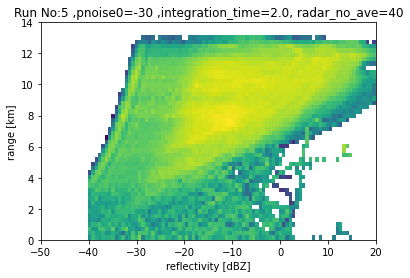

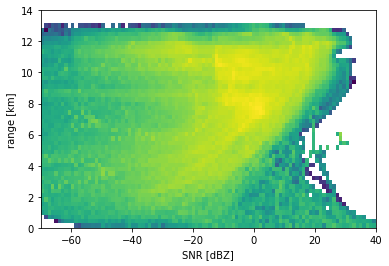

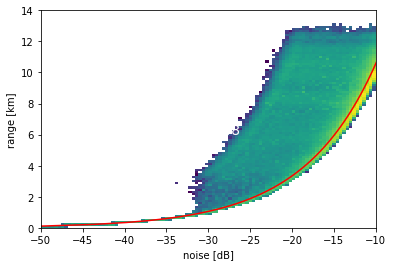

In [3]:
Ze = np.hstack(Zeflat)
Hgt = np.hstack(Hgtflat)
SNR = np.hstack(SNRflat)
N = np.hstack(Nflat)

SNR[SNR<-80] = np.nan
Ze[Ze<-40] = np.nan


cmap='viridis'
fig1 = plt.figure()
Y = Ze
X = Hgt 
res = plt.hist2d(Y,X, bins=(100,50), range=((-50, 20),(0,14)), cmap=cmap, norm=mpl_col.LogNorm())
plt.title('Run No:'+ str(RunNo)  +' ,pnoise0='+str(pam.nmlSet['radar_pnoise0'])  + ' ,integration_time='+str(pam.nmlSet['radar_integration_time'])
         +', radar_no_ave='+str(pam.nmlSet['radar_no_ave'])
         , wrap=True)
plt.xlabel('reflectivity [dBZ]')
plt.ylabel('range [km]')


fig2 = plt.figure()
Y = SNR
X = Hgt 
res = plt.hist2d(Y,X, bins=(100,50), range=((-70, 40),(0,14)), cmap=cmap, norm=mpl_col.LogNorm())
plt.xlabel('SNR [dBZ]')
plt.ylabel('range [km]')


fig3 = plt.figure()
Y = N
X = Hgt
res = plt.hist2d(Y,X, bins=(100,100), range=((-50, -10),(0,14)), cmap=cmap, norm=mpl_col.LogNorm())

mask = (np.isfinite(X) * (np.isfinite(Y)))
def func(x, a):
    return a*x*x;
popt, pcov = curve_fit(func, X[mask], 10.0**(0.1*Y[mask]))
x = np.linspace(0.1, 12, 100)
y = func(x, *popt)
#plt.xlim(0, 0.000001)
plt.plot(dB(y), x, c='red')
plt.text(-35, 6, 'P0={:.2f}'.format(dB(popt[0])), fontsize=14, color='white')
plt.xlabel('noise [dB]')
plt.ylabel('range [km]')

# customizing runtime configuration stored
# in matplotlib.rcParams
plt.rcParams["figure.figsize"] = [7.00, 3.50]
plt.rcParams["figure.autolayout"] = True


def save_image(filename):
	
	# PdfPages is a wrapper around pdf
	# file so there is no clash and create
	# files with no error.
	p = PdfPages(filename)
	
	# get_fignums Return list of existing
	# figure numbers
	fig_nums = plt.get_fignums()
	figs = [plt.figure(n) for n in fig_nums]
	
	# iterating over the numbers in list
	for fig in figs:
		
		# and saving the files
		fig.savefig(p, format='pdf')
	
	# close the object
	p.close()


# name your Pdf file
filename = "pamtra_Haloac3_allstats_"+str(RunNo)+".pdf"

# call the function
save_image(filename)

In [4]:
print(str(pam.nmlSet['radar_fwhr_beamwidth_deg']))

1.0
